# Assignment 4
### Do three of four.

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import seaborn as sns

### Exercise 1: Contingent Comparisons
- Load the Minnesota use of force data.
- Bootstrap the proportion of missing values for `subject_injury` for each race, and plot the results with grouped KDE and ECDF plots
- Describe what you see. When we consider second order uncertainty, how similar or different are the sampling distributions of these proportions? 

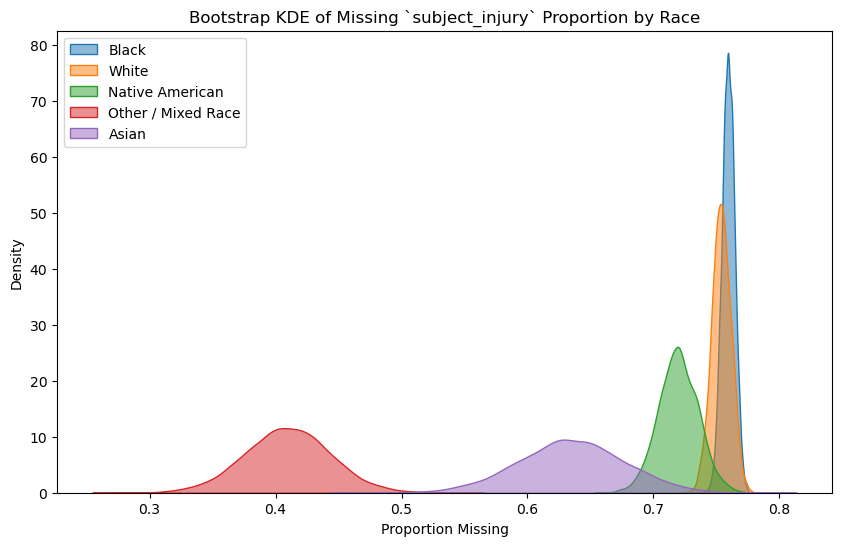

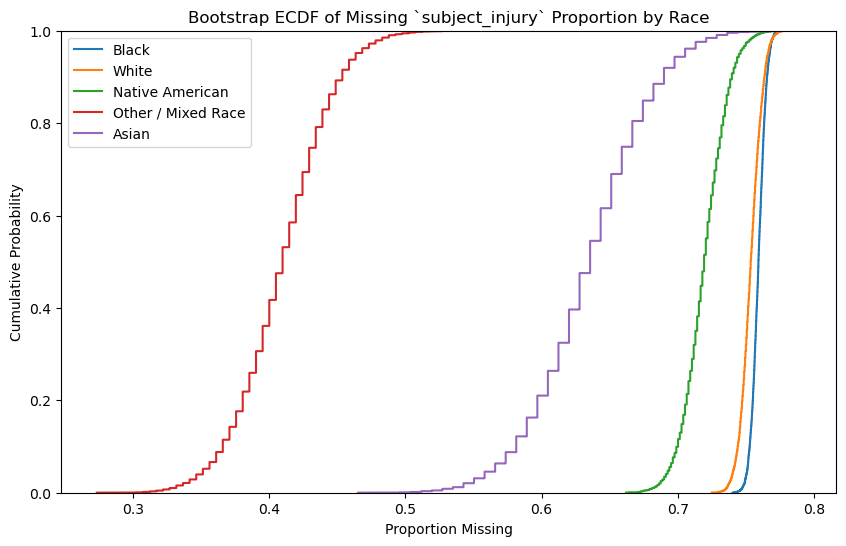

In [ ]:
minnesota_data = pd.read_csv('data/mn_police_use_of_force.csv', parse_dates=['response_datetime'])
races = minnesota_data['race'].dropna().unique().tolist()

if "Pacific Islander" in races:
    races.remove("Pacific Islander")

def bootstrap_missing(df, race, n_boot=5000):
    subset = df[df['race'] == race]
    n = len(subset)
    props = []
    for _ in range(n_boot):
        sample = subset.sample(n, replace=True)
        props.append(sample['subject_injury'].isna().mean())
    return np.array(props)

boot_results = {race: bootstrap_missing(minnesota_data, race) for race in races}

# KDE
plt.figure(figsize=(10,6))
for race, vals in boot_results.items():
    sns.kdeplot(vals, label=race, fill=True, alpha=0.5)
plt.title("Bootstrap KDE of Missing `subject_injury` Proportion by Race")
plt.xlabel("Proportion Missing")
plt.ylabel("Density")
plt.legend()
plt.show()

# ECDF
plt.figure(figsize=(10,6))
for race, vals in boot_results.items():
    sns.ecdfplot(vals, label=race)
plt.title("Bootstrap ECDF of Missing `subject_injury` Proportion by Race")
plt.xlabel("Proportion Missing")
plt.ylabel("Cumulative Probability")
plt.legend()
plt.show()

### Exercise 2: Invitation to Inference
- Run the simulation code line by line and comment what each line is doing, or write your own code to do the resampling
- Open the NHANES or Ames prices or College Completion data
- Use the above function `simulate` to get a sample of estimates for your statistic and your data
- Create a new function, `interval(L,H,estimates)`, that computes the $L$-th and $H$-th quantiles for your estimates, $H>L$
- If $L=.05$ and $H=.95$, this is a **90-percent confidence interval**: "For our statistic, this interval captures the true value of the population parameter 90 percent of the time. (We are 90% **confident** that it includes the true value of the parameter, but the probability that the true parameter lies in this interval is 0 or 1.)"
- We will spend much more time on this later in class, but for people who have done hypothesis testing before, you now know how to do it directly from the data: No central limit theorem required.

In [46]:
nhanes_data = pd.read_csv('data/nhanes_data_17_18.csv', low_memory=False)
nhanes_data.head()

,SEQN,GeneralHealthCondition,EverBreastfedOrFedBreastmilk,AgeStoppedBreastfeedingdays,AgeFirstFedFormuladays,AgeStoppedReceivingFormuladays,AgeStartedOtherFoodbeverage,AgeFirstFedMilkdays,TypeOfMilkFirstFedWholeMilk,TypeOfMilkFirstFed2Milk,...,DaysSmokedCigsDuringPast30Days,AvgCigarettesdayDuringPast30Days,TriedToQuitSmoking,TimesStoppedSmokingCigarettes,HowLongWereYouAbleToStopSmoking,UnitOfMeasureDayweekmonthyear_2_SMQ,CurrentSelfreportedHeightInches,CurrentSelfreportedWeightPounds,TriedToLoseWeightInPastYear,TimesLost10LbsOrMoreToLoseWeight
0,93703.0,NaN,1.0,273.0,1.0,365.0,152.0,365.0,Whole or regular milk,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,93704.0,NaN,1.0,60.0,3.0,365.0,126.0,365.0,Whole or regular milk,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,93705.0,Good,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,63.0,165.0,0.0,11 times or more
3,93706.0,Very good,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,68.0,145.0,0.0,Never
4,93707.0,Good,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Exercise 3: Intro to A/B Testing
- Go here, and read about this study: https://www.clinicaltrials.gov/study/NCT01985360
- Read the Study Overview and explain what the goal of the trial is 
- Read the Study Plan and explain how it was designed and why -- there's lots of medical jargon, but the main point is how patients were assigned to interventions. 
- Read the Results Posted: Go to **Outcome Measures**. Explain how table 1 ("Incidence of Death from Any Cause or Myocardial Infarction") is a contingency table. These are the data for this exercise.
- What is the difference in surival rates between the invasive strategy and the conservative strategy?
- Bootstrap the survival rates for the two groups, and plot them as KDEs and ECDFs against one another
- Bootstrap the difference in surival rates, and plot it as a KDE and ECDF
- Is this an effective health intervention? Explain your answer clearly

This would be what CS people call **A/B testing** and everyone else called a **randomized controlled trial**: Using randomized assignment to detect the difference in outcomes between two groups. (We've just done a non-parametric version of a two-sample t-test.)

### Exercise 4: Prediction Uncertainty
- Pick a dataset and two continuous variables.
- Recall the LCLS estimator:
$$
\hat{y}(z) =  \frac{ \frac{1}{N} \sum_{i=1}^N y_i \times \frac{1}{h}k\left( \frac{z - x_i}{h} \right)}{ \frac{1}{N} \sum_{i=1}^N \frac{1}{h} k\left( \frac{z - x_i}{h} \right)}
$$
with the Epanechnikov kernel and the standard plug-in bandwidth for $h$
- Compute and plot this line for 30 bootstrap samples. Notice where there is a lot of variation in the predictions, versus little variation in the predictions.
- Now, for any $z$, we can bootstrap a distribution of predictions using the above formula. Do this at the 25th percentile, median, and 75th percentile of $X$, and make KDE plots of your results.
- Now, pick a grid for $z$: Obvious choices are all of the unique values in the data, or an equally spaced grid from the minimum value to the maximum value. For each $z$, bootstrap a sample of predictions and compute the .05 and .95 quantiles. Plot these error curves along with your LCLS estimate. Where are your predictions "tight"/reliable? Where are they highly variable/unreliable?